# Analysis of PIK3CA variants

In the following we compare predictions from Rhapsody, PolyPhen-2, EVmutation and other methods on PIK3CA variants presented in:
* [Dogruluk T et al, *Identification of Variant-Specific Functions of PIK3CA by Rapid Phenotyping of Rare Mutations*, Cancer Res. (2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4681596/)
* [Zhang Y et al, *A Pan-Cancer Proteogenomic Atlas of PI3K/AKT/mTOR Pathway Alterations*, Cancer Cell (2017)](https://www.sciencedirect.com/science/article/pii/S153561081730168X?via%3Dihub)

In [1]:
import sys, os, pickle, csv, glob
import numpy as np

In [2]:
# Insert here local path to Rhapsody folder
sys.path.insert(0, '../../rhapsody/')

## Re-training of unbiased classifier

A few PIK3CA mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot names for gene PIK3CA are `P42336` or `PK3CA_HUMAN`.

In [3]:
from rhapsody import *

In [4]:
ID = pickle.load(open('../RF_training/Integrated_Dataset.pkl', 'rb'))

ID_del = ID[ID['true_label']==1]
ID_neu = ID[ID['true_label']==0]

known_del_SAVs = [SAV['SAV_coords'] for SAV in ID_del if SAV['SAV_coords'].startswith('P42336')]
known_neu_SAVs = [SAV['SAV_coords'] for SAV in ID_neu if SAV['SAV_coords'].startswith('P42336')]

print(f'{len(known_del_SAVs)} known deleterious PIK3CA SAVs:')
print(known_del_SAVs)
print(f'\n{len(known_neu_SAVs)} known neutral PIK3CA SAVs:')
print(known_neu_SAVs)

40 known deleterious PIK3CA SAVs:
['P42336 542 E K', 'P42336 545 E K', 'P42336 545 E G', 'P42336 1047 H R', 'P42336 1065 H Y', 'P42336 546 Q P', 'P42336 343 Y C', 'P42336 1021 Y H', 'P42336 1050 G D', 'P42336 1052 T K', 'P42336 1065 H L', 'P42336 1021 Y N', 'P42336 1025 T N', 'P42336 453 E Q', 'P42336 1023 R Q', 'P42336 542 E V', 'P42336 546 Q R', 'P42336 365 E K', 'P42336 378 C Y', 'P42336 726 E K', 'P42336 1025 T A', 'P42336 1035 A V', 'P42336 135 E K', 'P42336 218 E K', 'P42336 356 V I', 'P42336 38 R H', 'P42336 106 G V', 'P42336 81 E K', 'P42336 88 R Q', 'P42336 420 C R', 'P42336 545 E A', 'P42336 1021 Y C', 'P42336 1043 M I', 'P42336 1047 H Y', 'P42336 364 G R', 'P42336 914 G R', 'P42336 1049 G S', 'P42336 118 G D', 'P42336 382 R K', 'P42336 112 I N']

3 known neutral PIK3CA SAVs:
['P42336 391 I M', 'P42336 43 I V', 'P42336 332 S R']


Let's exclude these variants from the dataset. We will also only consider variants with associated PDB structures larger than 150 residues, which we found to improve prediction accuracy. 

In [5]:
ID_subset = ID[ [i for i,SAV in enumerate(ID) if not SAV['SAV_coords'].startswith('P42336') 
                                                 and SAV['PDB_length']>=150] ]
len(ID_subset)

23346

In [6]:
# complete set of Rhapsody features
full_clsf_featset = ['SAV_coords', 'true_label', 
                     'wt_PSIC', 'Delta_PSIC', 'SASA', 'ANM_MSF-chain', 
                     'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                     'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM']
# reduced set of Rhapsody features (without features computed on Pfam domains)
redx_clsf_featset = [f for f in full_clsf_featset if f not in ['entropy', 'ranked_MI']]

In [7]:
if os.path.isdir('results'):
    print('results already precomputed')
else:
    os.mkdir('results/')

results already precomputed


In [8]:
# training of full classifier
if os.path.isdir('results/full_clsf'):
    print('full classifier already trained')
else:
    os.mkdir('results/full_clsf')
    full_clsf = trainRFclassifier(ID_subset[full_clsf_featset])
    for file in glob.glob('*png') + ['trained_classifier.pkl',]:
        os.rename(file, os.path.join('results/full_clsf', file))

full classifier already trained


In [9]:
# training of reduced classifier
if os.path.isdir('results/redx_clsf'):
    print('reduced classifier already trained')
else:
    os.mkdir('results/redx_clsf')
    redx_clsf = trainRFclassifier(ID_subset[redx_clsf_featset])
    for file in glob.glob('*png') + ['trained_classifier.pkl',]:
        os.rename(file, os.path.join('results/redx_clsf', file))

reduced classifier already trained


## Predictions
We will perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis).

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [10]:
if os.path.isdir('results/predictions'):
    print('predictions already precomputed')
    rh = pickle.load(open('results/predictions/rhapsody-pickle.pkl', 'rb'))
else:
    os.mkdir('results/predictions')
    # run rhapsody
    rh = rhapsody('data/pph2/pph2-full.txt', 'results/full_clsf/trained_classifier.pkl',
                  aux_classifier='results/redx_clsf/trained_classifier.pkl', input_type='PP2')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('results/predictions', f))

predictions already precomputed


In [11]:
# import EVmutation scores
rh.calcEVmutationFeats()

@> Recovering EVmutation data...
@> EVmutation scores recovered in 31.2s.


array([(nan, nan, nan, nan), (nan, nan, nan, nan), (nan, nan, nan, nan),
       ..., (nan, nan, nan, nan), (nan, nan, nan, nan),
       (nan, nan, nan, nan)],
      dtype=[('EVmut-DeltaE_epist', '<f4'), ('EVmut-DeltaE_indep', '<f4'), ('EVmut-mut_aa_freq', '<f4'), ('EVmut-wt_aa_cons', '<f4')])

## Comparison with experimental data from Dogruluk et al.

We compare Rhapsody predictions and those from other methods cited in the paper with the results from the 5 functional assays.

In [12]:
# import precomputed structured array with data from Dogruluk et al.
data_Dogruluk = pickle.load(open('data/Dogruluk_etal-data.pkl', 'rb'))
data_Dogruluk.dtype.names

('Variant',
 'COSMIC frequency',
 'GF-free survival',
 'Insulin-free survival',
 'Ba/F3',
 'Tumorigenesis',
 'Soft agar colonies',
 'Condel',
 'Condel score',
 'PolyPhen',
 'PolyPhen score',
 'SIFT',
 'SIFT score',
 'MutationAssessor',
 'MutationAssessor score',
 'CanDrA+CTS',
 'CanDrA+CTS score',
 'CanDrA+GEN',
 'CanDrA+GEN score',
 'CHASM driver score',
 'VEST functional score',
 'Mutation Taster',
 'Mutation Taster score')

In [13]:
assays = ['GF-free survival', 'Insulin-free survival', 'Ba/F3', 'Tumorigenesis', 'Soft agar colonies']

methods = ['Condel score', 'PolyPhen score', 'SIFT score', 
           'MutationAssessor score', 'CanDrA+CTS score', 'CanDrA+GEN score', 
           'CHASM driver score', 'VEST functional score', 'Mutation Taster score',
           'rhapsody', 'EVmutation', 'PolyPhen-2']

In [14]:
# select given variants among Rhapsody results
sel_SAVs_1 = []
for var in data_Dogruluk['Variant']:
    SAV = f'P42336 {var[1:-1]} {var[0]} {var[-1]}'
    sel_SAVs_1.append( np.where(rh.SAVcoords['text'] == SAV)[0][0] )

rhaps_SAVs  = rh.SAVcoords['text'][sel_SAVs_1]
rhaps_preds = rh.mixPreds['path. probability'][sel_SAVs_1]
rhaps_class = rh.mixPreds['path. class'][sel_SAVs_1]
EVmut_preds = - rh.calcEVmutationFeats()['EVmut-DeltaE_epist'][sel_SAVs_1]
pph2_preds  = np.array([l['pph2_prob'] for l in rh.PP2output], dtype=float)[sel_SAVs_1]
pph2_class  = np.array([l['pph2_class'] for l in rh.PP2output])[sel_SAVs_1]

In the following, we measure the classification accuracy of each method by computing the AUROC against the experimental measurements. For simplicity, we considered phenotype levels `{0, 1}` as neutral and `{2, 3}` as deleterious.

In [15]:
from sklearn.metrics import roc_auc_score as auroc

print(' '*19 + '  '.join([f'{m[:13]:<14}' for m in assays + ['average',]]))

for method in methods:
    if method == 'rhapsody':
        preds = rhaps_preds
    elif method == 'EVmutation':
        preds = EVmut_preds
    elif method == 'PolyPhen-2':
        preds = pph2_preds
    else:
        preds = data_Dogruluk[method]
    corrs = []
    aurocs = []
    for assay in assays + ['average',]:
        if assay == 'average':
            exp_data = [np.nanmean(list(r)) for r in data_Dogruluk[assays]]
        else:
            exp_data = data_Dogruluk[assay]
        # skip invalid (NaN) values
        exp_data = np.array( exp_data )
        preds    = np.array( preds )
        sel = np.isnan(exp_data * preds)
        # compute AUROC
        bin_labels = np.where(exp_data[~sel]<2, 0, 1)
        aurocs.append(auroc(bin_labels, preds[~sel]))
        
    m = method.replace(' score', '')
    if method == 'rhapsody':
        print('-'*110)
    print(f'{m:<18} ' + '  '.join([f'{a:<13.3f} ' for a in aurocs]))

                   GF-free survi   Insulin-free    Ba/F3           Tumorigenesis   Soft agar col   average       
Condel             0.604           0.483           0.604           0.389           0.497           0.530         
PolyPhen           0.696           0.493           0.696           0.500           0.556           0.652         
SIFT               0.509           0.500           0.509           0.692           0.583           0.573         
MutationAssessor   0.616           0.441           0.616           0.442           0.580           0.573         
CanDrA+CTS         0.554           0.403           0.554           0.500           0.562           0.570         
CanDrA+GEN         0.682           0.627           0.682           0.688           0.794           0.715         
CHASM driver       0.387           0.434           0.387           0.428           0.497           0.394         
VEST functional    0.685           0.646           0.685           0.567           0.556

In the following, we compare the predictions between Rhapsody and PolyPhen-2 against the label found in the training dataset, when present, and the experimental *average* results. The last column shows the standard deviation of the experimental measurements, which indicates the degree of accord between the 5 assays.

In [16]:
print(f'{"":20} {"rhapsody":15} {"PolyPhen-2":15} {"trainining":10} {"exp":>10} {"(std)":>10}')

for i, SAV in enumerate(rhaps_SAVs):
    if SAV in known_del_SAVs:
        status = 'known_del'
    elif SAV in known_neu_SAVs:
        status = 'known_neu'
    else:
        status = '-'
    exp_mean = np.nanmean(list(data_Dogruluk[assays][i]))
    exp_std  = np.nanstd(list(data_Dogruluk[assays][i]))
    print(f'{SAV:20} {rhaps_class[i]:15} {pph2_class[i]:15} {status:10} {exp_mean:>10.2f} {exp_std:>10.2f}')

                     rhapsody        PolyPhen-2      trainining        exp      (std)
P42336 31 I M        neutral         neutral         -                0.00       0.00
P42336 111 K N       prob.delet.     deleterious     -                1.00       0.89
P42336 345 N I       deleterious     deleterious     -                1.00       0.63
P42336 345 N K       deleterious     deleterious     -                2.50       0.50
P42336 420 C R       neutral         deleterious     known_del        2.25       0.43
P42336 453 E K       neutral         deleterious     -                1.00       0.63
P42336 539 P R       deleterious     deleterious     -                0.80       0.40
P42336 542 E K       neutral         deleterious     known_del        2.75       0.43
P42336 542 E V       prob.neutral    deleterious     known_del        1.00       0.00
P42336 545 E K       neutral         deleterious     known_del        3.00       0.00
P42336 545 E Q       neutral         deleterious     -

We note the tendency of Rhapsody to assign a `neutral` prediction to variants that are found mostly pathogenic by experiment. In the following we focus especially on mutations at `E542`, `E545` and `Q546`.

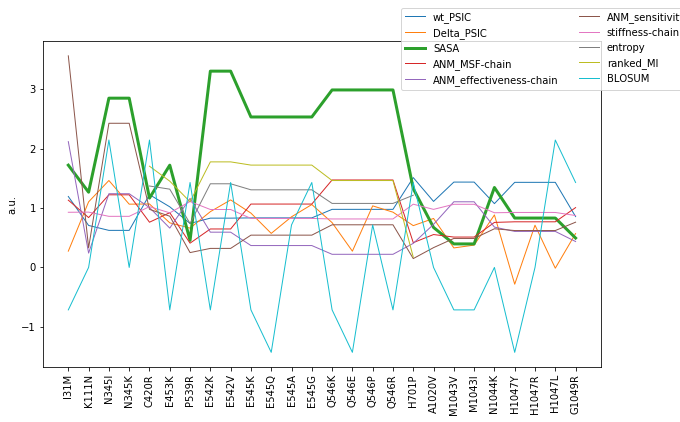

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,6))
for i,feat in enumerate(rh.featSet):
    p = rh.featMatrix[sel_SAVs_1,i] / np.nanmean(rh.featMatrix[:,i])
    lw = 3 if feat in ['SASA'] else 1
    ax.plot(p, label=feat, lw=lw)
ax.set_xticks(range(len(sel_SAVs_1)))
ax.set_xticklabels(data_Dogruluk['Variant'], rotation='vertical')
ax.set_ylabel('a.u.')
lgd = fig.legend(bbox_to_anchor=(0.55, 0.97), loc='upper left', ncol=2)

if not os.path.isdir('figures'):
    os.mkdir('figures')
fig.savefig('figures/features-Dogruluk.png', bbox_extra_artists=(lgd,), dpi=300)

It is difficult to try and interpret the motivation behind some prediction, but we notice that, e.g., position 542, 545 and 546 have a relatively hight solvent-accessible area. We can hypothesize that the Rhapsody classifier work best in region of structural interest, while for residues exposed on the surface it mainly relies on conservation/coevolution analysis. In this particular instance, the classifier is not able to predict the correct outcome of variants at those position.

## Comparison with experimental data from Zhang et al.

In [18]:
# import PIK3CA data from Zhang et al.
with open('data/Zhang_etal-data.csv') as csv_file:
    csv_read = list(csv.reader(csv_file))
    
# convert to structured array. Select only PIK3CA missense variants
dt = np.dtype([(f, 'U30') for f in csv_read[2]])
PIK3CA_lines = [x for x in csv_read if x[0]=='PIK3CA' and x[4]=='Missense_Mutation']
data_Zhang = np.empty(len(PIK3CA_lines), dtype=dt)
for i,l in enumerate(PIK3CA_lines):
    data_Zhang[i] = tuple(l)
data_Zhang.dtype.names

('Hugo_Symbol',
 'AA change',
 'Chromosome',
 'Start_position',
 'Variant_Classification',
 'Variant_Type',
 'number of samples',
 'number of patients',
 'Summary pred. functional (no functional assays)',
 'Taylor hotspot',
 'oncogene',
 'Mutation Assessor',
 'Additional literature assessment (D. Kwiatkowski)',
 'BaF3_Call',
 'MCF10A_Call',
 'AKT_pS473',
 'AKT_pT308',
 'MTOR_pS2448',
 'P70S6K_pT389',
 'S6_pS235S236',
 'S6_pS240S244',
 'PI3K/AKT sig',
 'mTOR sig',
 'f23',
 'f24')

In this case we will compare Rhapsody predictions with the columns `Summary pred. functional` and `Additional literature assessment` ("methods") and with the 2 experimental functional assays `BaF3_Call` and `MCF10A_Call`.

In [19]:
assays = ['BaF3_Call', 'MCF10A_Call']

methods = ['Summary pred. functional (no functional assays)', 'Additional literature assessment (D. Kwiatkowski)',
           'rhapsody', 'EVmutation', 'PolyPhen-2']

In [20]:
set(data_Zhang['Summary pred. functional (no functional assays)'])

{'0', '1'}

In [21]:
set(data_Zhang['Additional literature assessment (D. Kwiatkowski)'])

{'NA', 'likely', 'no', 'yes'}

In [22]:
set(data_Zhang['BaF3_Call'])

{'Moderate activating', 'NA', 'NDFW', 'Strong activating'}

In [23]:
set(data_Zhang['MCF10A_Call'])

{'Moderate activating',
 'N/A',
 'NA',
 'NDFW',
 'Strong activating',
 'Weak activating'}

We will use the following mapping, for simplicity:

In [24]:
mapping = {}
for case in ['NA', 'N/A']:
    mapping[case] = np.nan
for case in ['0', 'NDFW', 'no']:
    mapping[case] = 0
for case in ['Weak activating',]:
    mapping[case] = 1
for case in ['Moderate activating', 'likely']:
    mapping[case] = 2
for case in ['Strong activating', 'yes', '1']:
    mapping[case] = 3

In [25]:
# select given variants among Rhapsody results
sel_SAVs_2 = []
for var in data_Zhang['AA change']:
    SAV = f'P42336 {var[3:-1]} {var[2]} {var[-1]}'
    sel_SAVs_2.append( np.where(rh.SAVcoords['text'] == SAV)[0][0] )

rhaps_SAVs  = rh.SAVcoords['text'][sel_SAVs_2]
rhaps_preds = rh.mixPreds['path. probability'][sel_SAVs_2]
rhaps_class = rh.mixPreds['path. class'][sel_SAVs_2]
EVmut_preds = - rh.calcEVmutationFeats()['EVmut-DeltaE_epist'][sel_SAVs_2]
pph2_preds  = np.array([l['pph2_prob'] for l in rh.PP2output], dtype=float)[sel_SAVs_2]
pph2_class  = np.array([l['pph2_class'] for l in rh.PP2output])[sel_SAVs_2]

In [26]:
from sklearn.metrics import roc_auc_score as auroc

print(' '*35 + '  '.join([f'{m[:13]:<14}' for m in assays]))

for method in methods:
    if method == 'rhapsody':
        preds = rhaps_preds
    elif method == 'EVmutation':
        preds = EVmut_preds
    elif method == 'PolyPhen-2':
        preds = pph2_preds
    else:
        preds = [mapping[x] for x in data_Zhang[method]]
    corrs = []
    aurocs = []
    for assay in assays:
        exp_data = [mapping[x] for x in data_Zhang[assay]]
        # skip invalid (NaN) values
        exp_data = np.array( exp_data )
        preds    = np.array( preds )
        sel = np.isnan(exp_data * preds)
        # compute AUROC
        bin_labels = np.where(exp_data[~sel]<2, 0, 1)
        aurocs.append(auroc(bin_labels, preds[~sel]))
        
    m = method.split('(')[0]
    if method == 'rhapsody':
        print('-'*110)
    print(f'{m:<34} ' + '  '.join([f'{a:<13.3f} ' for a in aurocs]))

                                   BaF3_Call       MCF10A_Call   
Summary pred. functional           0.600           0.543         
Additional literature assessment   0.797           0.620         
--------------------------------------------------------------------------------------------------------------
rhapsody                           0.317           0.621         
EVmutation                         0.461           0.629         
PolyPhen-2                         0.362           0.530         


In [27]:
print(f'{"":20} {"rhapsody":15} {"PolyPhen-2":15} {"trainining":20} {"BaF3_Call":<20} {"MCF10A_Call":<20}')

for i, SAV in enumerate(rhaps_SAVs):
    if SAV in known_del_SAVs:
        status = 'known_del'
    elif SAV in known_neu_SAVs:
        status = 'known_neu'
    else:
        status = '-'
    exp1 = data_Zhang['BaF3_Call'][i]
    exp2 = data_Zhang['MCF10A_Call'][i]
    if exp1 == exp2 == 'NA':
        continue
    print(f'{SAV:20} {rhaps_class[i]:15} {pph2_class[i]:15} {status:20} {exp1:<20} {exp2:<20}')

                     rhapsody        PolyPhen-2      trainining           BaF3_Call            MCF10A_Call         
P42336 378 C Y       neutral         deleterious     known_del            Moderate activating  NDFW                
P42336 420 C R       neutral         deleterious     known_del            Strong activating    Strong activating   
P42336 971 C R       neutral         neutral         -                    NDFW                 Moderate activating 
P42336 350 D G       neutral         deleterious     -                    Moderate activating  Weak activating     
P42336 350 D N       neutral         deleterious     -                    Moderate activating  Weak activating     
P42336 365 E K       neutral         deleterious     known_del            Moderate activating  NDFW                
P42336 39 E K        neutral         deleterious     -                    Moderate activating  NA                  
P42336 453 E K       neutral         deleterious     -                  